# Modelling
## 1. Prepare for Modelling
### 1.1. Import libraries

In [155]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Data Split
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from pprint import pprint


In [156]:
# Disable Warnings
import warnings
warnings.filterwarnings("ignore")

### 1.2. Import data

In [157]:
# Substituir pelo df do feature selection 
all_data = pd.read_csv('data/processed/df_clustered.csv')

In [158]:
# Drop irrelevant variables for prediction (cluster) 
columns_to_remove=[col for col in all_data.columns if col.startswith('Cluster_')]
all_data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

### 1.3. Feature Selection

In [159]:
# Import scenarios generated in feature selection
scenario1_td = pd.read_csv('data/processed/scenario1.csv')
scenario2_td = pd.read_csv('data/processed/scenario2.csv')

# Other scenarios created in this notebook

scenario3 = all_data[["Customer ID", 'Senior Citizen','Dependents','Referred a Friend','Internet Service','Internet Type_Fiber Optic','Online Security','Offer_Offer E',
                     'Offer_Offer A','Premium Tech Support','Unlimited Data','Contract_Month-to-Month','Paperless Billing','Payment Method_Credit Card', 'Churn Score', 'Satisfaction Score']]

In [160]:
print(scenario2_td.columns)

Index(['Customer ID', 'Satisfaction Score', 'Churn Score',
       'Contract_Month-to-Month', 'Number of Referrals', 'Online Security',
       'Monthly Charge', 'Offer_Offer E', 'Offer_Offer A',
       'Contract_Two Year'],
      dtype='object')


In [161]:
print(scenario1_td.columns)

Index(['Customer ID', 'Satisfaction Score', 'Churn Score',
       'Contract_Month-to-Month', 'Number of Referrals', 'Online Security',
       'Monthly Charge'],
      dtype='object')


In [189]:
print(scenario3.columns)

Index(['Customer ID', 'Senior Citizen', 'Dependents', 'Referred a Friend',
       'Internet Service', 'Internet Type_Fiber Optic', 'Online Security',
       'Offer_Offer E', 'Offer_Offer A', 'Premium Tech Support',
       'Unlimited Data', 'Contract_Month-to-Month', 'Paperless Billing',
       'Payment Method_Credit Card'],
      dtype='object')


In [162]:
scenario1_td.drop(columns=['Churn Score', 'Satisfaction Score'], inplace=True, errors='ignore')
scenario2_td.drop(columns=['Churn Score', 'Satisfaction Score'], inplace=True, errors='ignore')
scenario3.drop(columns=['Churn Score', 'Satisfaction Score'], inplace=True, errors='ignore')

### 1.4. Data Split
> Train-Test split<p>
> Train data in predictors (X) and target variable (y)

In [163]:
# List to append the metrics of all the models
models_metrics =[]

In [164]:
def data_split(scenario):
    # Define the scenario to test
    df = scenario.copy()
    df.set_index("Customer ID", inplace=True)

    # Split
    X_total = df
    y_total = all_data[["Customer ID", "Churn Label"]]
    y_total.set_index("Customer ID", inplace=True)

    # Splitting the Data into Train and test with 20% test Data. Stratify dut to unbalance Dataset. (Only 27% Churn)
    X_train_total, X_test, y_train_total, y_test = train_test_split(X_total, y_total, test_size=0.20, random_state=1, stratify=y_total)

    return X_train_total, X_test, y_train_total, y_test

X_train_total, X_test, y_train_total, y_test = data_split(scenario3)

## 2. Baseline X_train
### 2.1 Logistic Regression - Train and Validation Results

In [165]:
def train_eval(model, X_train_total=X_train_total, X_test=X_test, y_train_total=y_train_total, y_test=y_test):
    # Feature scaling - scenario 1 already scaled
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X_train)

    # Create StratifiedKFold
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize variables to store Validation results
    train_accuracy_scores = []
    train_f1_scores = []

    # Initialize variables to store Validation results
    val_accuracy_scores = []
    val_f1_scores = []

    # Perform k-fold cross-validation
    for train_idx, val_idx in k_fold.split(X_train_total, y_train_total):
        X_train, X_val = X_train_total.iloc[train_idx], X_train_total.iloc[val_idx]
        y_train, y_val = y_train_total.iloc[train_idx], y_train_total.iloc[val_idx]

        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the training set  - To check potential overfitting
        y_train_pred = model.predict(X_train)

        # Evaluate the model on the validation set
        accuracy = accuracy_score(y_train, y_train_pred)
        train_accuracy_scores.append(round(accuracy,3))
        
        #F1 Score 
        f1 = f1_score(y_train, y_train_pred)
        train_f1_scores.append(round(f1,3))

        # Make predictions on the validation set
        y_val_pred = model.predict(X_val)

        # Evaluate the model on the validation set
        accuracy = accuracy_score(y_val, y_val_pred)
        val_accuracy_scores.append(round(accuracy,3))
        
        #F1 Score 
        f1 = f1_score(y_val, y_val_pred)
        val_f1_scores.append(round(f1,3))


    #Training
    # Print accuracy results
    print("--- Training ---")
    print("Accuracy:")
    print(f'Cross-Validation Accuracy: {train_accuracy_scores}')
    print(f'Mean Accuracy: {round(sum(train_accuracy_scores) / len(train_accuracy_scores),3)}\n')

    # Print F1 results
    print("F1 Score:")
    print(f'Cross-Validation F1: {train_f1_scores}')
    print(f'Mean F1: {round(sum(train_f1_scores) / len(train_f1_scores),3)}\n')

    #Validation
    # Print accuracy results
    print("--- Validation ---")
    print("Accuracy:")
    print(f'Cross-Validation Accuracy: {val_accuracy_scores}')
    print(f'Mean Accuracy: {round(sum(val_accuracy_scores) / len(val_accuracy_scores),3)}\n')

    # Print F1 results
    print("F1 Score:")
    print(f'Cross-Validation F1: {val_f1_scores}')
    print(f'Mean F1: {round(sum(val_f1_scores) / len(val_f1_scores),3)}\n')

    # Fit Model to total Training Data
    model.fit(X_train_total, y_train_total)

    # Make predictions on the Test set
    y_test_pred = model.predict(X_test)

    # Evaluate the model on the Test set
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    #Print Test Scores
    print("--- Test ---")
    print(f'Accuracy: {round(accuracy,3)}')
    print(f'F1: {round(f1,3)}')

    metrics = {
    "Model": str(model).split("(")[0], 
    "Accuracy Training": round(sum(train_accuracy_scores) / len(train_accuracy_scores), 3),
    "Accuracy Validation": round(sum(val_accuracy_scores) / len(val_accuracy_scores), 3),
    "Accuracy Test": round(accuracy, 3),
    "F1 Training": round(sum(train_f1_scores) / len(train_f1_scores), 3),
    "F1 Validation": round(sum(val_f1_scores) / len(val_f1_scores), 3),
    "F1 Test": round(f1, 3)
}


    models_metrics.append(metrics)

In [166]:
train_eval(LogisticRegression())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.82, 0.824, 0.821, 0.817, 0.821]
Mean Accuracy: 0.821

F1 Score:
Cross-Validation F1: [0.653, 0.653, 0.653, 0.646, 0.656]
Mean F1: 0.652

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.824, 0.806, 0.819, 0.831, 0.813]
Mean Accuracy: 0.819

F1 Score:
Cross-Validation F1: [0.653, 0.62, 0.655, 0.672, 0.642]
Mean F1: 0.648

--- Test ---
Accuracy: 0.828
F1: 0.666


### 2.2 Decision Tree - Train and Validation Results


In [167]:
train_eval(DecisionTreeClassifier(max_depth=3))

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.781, 0.791, 0.793, 0.781, 0.782]
Mean Accuracy: 0.786

F1 Score:
Cross-Validation F1: [0.365, 0.62, 0.62, 0.355, 0.36]
Mean F1: 0.464

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.783, 0.778, 0.772, 0.787, 0.782]
Mean Accuracy: 0.78

F1 Score:
Cross-Validation F1: [0.351, 0.598, 0.599, 0.391, 0.37]
Mean F1: 0.462

--- Test ---
Accuracy: 0.787
F1: 0.38


### 2.3. Random Forest - Train and Validation Results


In [168]:
train_eval(RandomForestClassifier(max_depth=3))

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.79, 0.798, 0.779, 0.78, 0.784]
Mean Accuracy: 0.786

F1 Score:
Cross-Validation F1: [0.418, 0.457, 0.333, 0.332, 0.355]
Mean F1: 0.379

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.796, 0.779, 0.783, 0.782, 0.775]
Mean Accuracy: 0.783

F1 Score:
Cross-Validation F1: [0.439, 0.397, 0.351, 0.349, 0.314]
Mean F1: 0.37

--- Test ---
Accuracy: 0.797
F1: 0.45


In [169]:
pprint(models_metrics)

[{'Accuracy Test': 0.828,
  'Accuracy Training': 0.821,
  'Accuracy Validation': 0.819,
  'F1 Test': 0.666,
  'F1 Training': 0.652,
  'F1 Validation': 0.648,
  'Model': 'LogisticRegression'},
 {'Accuracy Test': 0.787,
  'Accuracy Training': 0.786,
  'Accuracy Validation': 0.78,
  'F1 Test': 0.38,
  'F1 Training': 0.464,
  'F1 Validation': 0.462,
  'Model': 'DecisionTreeClassifier'},
 {'Accuracy Test': 0.797,
  'Accuracy Training': 0.786,
  'Accuracy Validation': 0.783,
  'F1 Test': 0.45,
  'F1 Training': 0.379,
  'F1 Validation': 0.37,
  'Model': 'RandomForestClassifier'}]


### 2.4 SVC - Train and Validation Results

In [170]:
train_eval(SVC())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.826, 0.834, 0.827, 0.826, 0.827]
Mean Accuracy: 0.828

F1 Score:
Cross-Validation F1: [0.645, 0.658, 0.642, 0.638, 0.643]
Mean F1: 0.645

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.827, 0.807, 0.817, 0.834, 0.823]
Mean Accuracy: 0.822

F1 Score:
Cross-Validation F1: [0.634, 0.608, 0.62, 0.657, 0.647]
Mean F1: 0.633

--- Test ---
Accuracy: 0.828
F1: 0.646


### 2.5 Gaussian - Train and Validation Results

In [171]:
train_eval(GaussianNB())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.764, 0.767, 0.761, 0.763, 0.767]
Mean Accuracy: 0.764

F1 Score:
Cross-Validation F1: [0.637, 0.637, 0.632, 0.634, 0.639]
Mean F1: 0.636

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.745, 0.773, 0.772, 0.766, 0.759]
Mean Accuracy: 0.763

F1 Score:
Cross-Validation F1: [0.621, 0.644, 0.646, 0.637, 0.623]
Mean F1: 0.634

--- Test ---
Accuracy: 0.764
F1: 0.636


### 2.6 KNN - Train and Validation Results

In [172]:
train_eval(KNeighborsClassifier())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.816, 0.822, 0.816, 0.821, 0.816]
Mean Accuracy: 0.818

F1 Score:
Cross-Validation F1: [0.61, 0.598, 0.604, 0.61, 0.604]
Mean F1: 0.605

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.8, 0.791, 0.799, 0.798, 0.783]
Mean Accuracy: 0.794

F1 Score:
Cross-Validation F1: [0.573, 0.53, 0.566, 0.555, 0.527]
Mean F1: 0.55

--- Test ---
Accuracy: 0.804
F1: 0.584


### 2.7 Gradient Boosting - Train and Validation Results

In [173]:
train_eval(GradientBoostingClassifier())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.827, 0.833, 0.828, 0.827, 0.828]
Mean Accuracy: 0.829

F1 Score:
Cross-Validation F1: [0.653, 0.659, 0.656, 0.653, 0.652]
Mean F1: 0.655

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.823, 0.813, 0.826, 0.826, 0.821]
Mean Accuracy: 0.822

F1 Score:
Cross-Validation F1: [0.635, 0.62, 0.651, 0.65, 0.644]
Mean F1: 0.64

--- Test ---
Accuracy: 0.828
F1: 0.654


### 2.8 MLP - Train and Validation Results

In [174]:
train_eval(MLPClassifier())

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.835, 0.84, 0.833, 0.836, 0.833]
Mean Accuracy: 0.835

F1 Score:
Cross-Validation F1: [0.646, 0.673, 0.653, 0.66, 0.67]
Mean F1: 0.66

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.825, 0.804, 0.822, 0.815, 0.823]
Mean Accuracy: 0.818

F1 Score:
Cross-Validation F1: [0.617, 0.602, 0.637, 0.611, 0.655]
Mean F1: 0.624

--- Test ---
Accuracy: 0.831
F1: 0.653


In [175]:
# Coonvert List of Models Metrics to DF
models_metrics_df = pd.DataFrame(models_metrics)

In [176]:
models_metrics_df.sort_values(by=['F1 Test'], ascending=False)

,Model,Accuracy Training,Accuracy Validation,Accuracy Test,F1 Training,F1 Validation,F1 Test
0,LogisticRegression,0.821,0.819,0.828,0.652,0.648,0.666
6,GradientBoostingClassifier,0.829,0.822,0.828,0.655,0.640,0.654
7,MLPClassifier,0.835,0.818,0.831,0.660,0.624,0.653
3,SVC,0.828,0.822,0.828,0.645,0.633,0.646
4,GaussianNB,0.764,0.763,0.764,0.636,0.634,0.636
5,KNeighborsClassifier,0.818,0.794,0.804,0.605,0.550,0.584
2,RandomForestClassifier,0.786,0.783,0.797,0.379,0.370,0.450
1,DecisionTreeClassifier,0.786,0.780,0.787,0.464,0.462,0.380


> Decision Trees:
Intuitive and easy to understand.
Can capture complex relationships in the data.

> Random Forest:
Ensemble method built on decision trees.
Generally more robust and accurate than individual trees.

> Support Vector Machines (SVM):
Effective in high-dimensional spaces.
Works well when there is a clear margin of separation between classes.

> Naive Bayes:
Assumes independence between features.
Fast and can perform well on certain types of data.

> K-Nearest Neighbors (KNN):
Instance-based learning.
Simple and easy to understand.

> Gradient Boosting (e.g., XGBoost, LightGBM, AdaBoost):
Builds a strong predictive model by combining weak models.
Often produces very accurate results.

## 3. Model Optimization


### 3.1.1 RandomSearch - Gradient Boosting

In [190]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Create the Gradient Boosting model (without specifying hyperparameters)
gb_model = GradientBoostingClassifier()

# Define the parameter space for random search
parameter_space_random = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': np.arange(0.1, 1.1, 0.1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=parameter_space_random,
                                    scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_total, y_train_total)

# Print the best parameters
#print("Best Parameters: ", random_search.best_params_)

# Extract the best parameters and their scores from RandomizedSearchCV
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Create a DataFrame to store the results
results_rs_gb = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in best_params_random.items():
    results_rs_gb = pd.concat([results_rs_gb, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_rs_gb = pd.concat([results_rs_gb, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [best_score_random]})])

# Display the results DataFrame
results_rs_gb




,Parameter,Best Result
0,subsample,0.5
0,n_estimators,100.0
0,min_samples_split,2.0
0,min_samples_leaf,4.0
0,max_features,sqrt
0,max_depth,3
0,learning_rate,0.3
0,Best Score,0.634454


### 3.1.2 GridSearch - Gradient Boosting

In [191]:
# Create the Gradient Boosting model (without specifying hyperparameters)
gb_model = GradientBoostingClassifier()

# Define the parameter grid for grid search
parameter_grid = {
    'n_estimators': [80,100,120],
    'learning_rate': [0.2,0.3,0.4],
    'max_depth': [2.5,2.7,3,3.1,3.2,4],
    'subsample': [0.5,0.6,0.4,0.3,0.7],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_samples_split': [1,2,3,4,5],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_model, param_grid=parameter_grid,
                           scoring='f1', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_total, y_train_total)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Create a DataFrame to store the results
results_gs_gb = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in grid_search.best_params_.items():
    results_gs_gb = pd.concat([results_gs_gb, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_gs_gb= pd.concat([results_gs_gb, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [grid_search.best_score_]})])

# Display the results DataFrame
results_gs_gb


Best Parameters:  {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'subsample': 0.6}


,Parameter,Best Result
0,learning_rate,0.2
0,max_depth,3.0
0,max_features,sqrt
0,min_samples_split,2
0,n_estimators,80
0,subsample,0.6
0,Best Score,0.648956


### 3.1.3 Final Model - GB

In [192]:
final_model_gb = GradientBoostingClassifier(
    n_estimators=80,
    learning_rate=0.2,
    max_depth=3,
    subsample=0.6,
    max_features='sqrt',
    min_samples_split=2,
)


In [193]:
train_eval(final_model_gb)

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.827, 0.828, 0.826, 0.824, 0.827]
Mean Accuracy: 0.826

F1 Score:
Cross-Validation F1: [0.658, 0.655, 0.652, 0.644, 0.647]
Mean F1: 0.651

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.819, 0.81, 0.827, 0.825, 0.821]
Mean Accuracy: 0.82

F1 Score:
Cross-Validation F1: [0.626, 0.616, 0.656, 0.645, 0.647]
Mean F1: 0.638

--- Test ---
Accuracy: 0.833
F1: 0.655


### 3.2.1 RandomSearch - SVC

In [194]:
# Create the Support Vector Classification (SVC) model (without specifying hyperparameters)
model_SVC = SVC()

# Define the parameter space for random search
parameter_space_random = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-4],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': [None, 'balanced'],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_SVC, param_distributions=parameter_space_random,
                                    scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_total, y_train_total)  # Make sure X_total and y_total are defined

# Extract the best parameters and their scores from RandomizedSearchCV
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Create a DataFrame to store the results
results_rs_svc = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in best_params_random.items():
    results_rs_svc = pd.concat([results_rs_svc, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_rs_svc = pd.concat([results_rs_svc, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [best_score_random]})])

# Display the results DataFrame
results_rs_svc


,Parameter,Best Result
0,kernel,linear
0,gamma,0.001
0,class_weight,None
0,C,1
0,Best Score,0.643127


### 3.2.2 GridSearch - SVC

In [195]:
# Create the Support Vector Classification (SVC) model (without specifying hyperparameters)
model_SVC = SVC()

# Define the parameter grid for grid search
parameter_space_grid = {
    'C': [1, 2, 3,4],
    'gamma': [1e-4, 2e-4, 0.5e-4],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': [None, 'balanced'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_SVC, param_grid=parameter_space_grid,
                           scoring='f1', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_total, y_train_total)  # Make sure X_total and y_total are defined

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Create a DataFrame to store the results
results_gs_scv = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in grid_search.best_params_.items():
    results_gs_scv = pd.concat([results_gs_scv, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_gs_scv = pd.concat([results_gs_scv, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [grid_search.best_score_]})])

# Display the results DataFrame
results_gs_scv


Best Parameters:  {'C': 1, 'class_weight': None, 'gamma': 0.0001, 'kernel': 'linear'}


,Parameter,Best Result
0,C,1
0,class_weight,None
0,gamma,0.0001
0,kernel,linear
0,Best Score,0.643127


### 3.2.3 Final Model -SVC

In [196]:
final_model_svc = SVC(
    C=1,
    class_weight=None,
    gamma=0.0001,
    kernel='linear',
    max_iter=2000,
)

In [197]:
train_eval(final_model_svc)

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.812, 0.819, 0.812, 0.816, 0.819]
Mean Accuracy: 0.816

F1 Score:
Cross-Validation F1: [0.659, 0.66, 0.657, 0.655, 0.66]
Mean F1: 0.658

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.815, 0.802, 0.806, 0.829, 0.809]
Mean Accuracy: 0.812

F1 Score:
Cross-Validation F1: [0.655, 0.636, 0.654, 0.68, 0.637]
Mean F1: 0.652

--- Test ---
Accuracy: 0.819
F1: 0.661


### 3.3.1 RandomSearch - MLP

In [183]:
# Create the Multi-Layer Perceptron (MLP) model (without specifying hyperparameters)
model_MLP = MLPClassifier()

# Define the parameter space for random search
parameter_space_random = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_MLP, param_distributions=parameter_space_random,
                                    scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_total, y_train_total)  # Make sure X_total and y_total are defined

# Extract the best parameters and their scores from RandomizedSearchCV
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Create a DataFrame to store the results
results_rs_mlp = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in best_params_random.items():
    results_rs_mlp = pd.concat([results_rs_mlp, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_rs_mlp = pd.concat([results_rs_mlp, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [best_score_random]})])

# Display the results DataFrame
results_rs_mlp


,Parameter,Best Result
0,solver,sgd
0,learning_rate,constant
0,hidden_layer_sizes,"(50, 50, 50)"
0,alpha,0.05
0,activation,tanh
0,Best Score,0.647323


### 3.3.2 GridSearch - MLP

In [198]:
# Create the Support Vector Classification (SVC) model (without specifying hyperparameters)
model_MLP = MLPClassifier()

# Define the parameter grid for grid search
parameter_space_grid = {
    'hidden_layer_sizes': [(50,50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.5, 0.4,0.3,0.6],
    'learning_rate': ['constant', 'adaptive'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_MLP, param_grid=parameter_space_grid,
                           scoring='f1', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_total, y_train_total)  # Make sure X_total and y_total are defined

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Create a DataFrame to store the results
results_gs_mlp = pd.DataFrame(columns=['Parameter', 'Best Result'])

# Add the best parameters and scores to the DataFrame
for param, value in grid_search.best_params_.items():
    results_gs_mlp = pd.concat([results_gs_mlp, pd.DataFrame({'Parameter': [param], 'Best Result': [value]})])

# Add the best score to the DataFrame
results_gs_mlp = pd.concat([results_gs_mlp, pd.DataFrame({'Parameter': ['Best Score'], 'Best Result': [grid_search.best_score_]})])

# Display the results DataFrame
results_gs_mlp

Best Parameters:  {'activation': 'tanh', 'alpha': 0.3, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


,Parameter,Best Result
0,activation,tanh
0,alpha,0.3
0,hidden_layer_sizes,"(50, 50, 50)"
0,learning_rate,constant
0,solver,adam
0,Best Score,0.649894


### 3.3.3 Final Model -MLP

In [199]:
final_model_mlp = MLPClassifier(
    activation='tanh',
    alpha=0.3,
    hidden_layer_sizes=(50, 50, 50),
    learning_rate='constant',
    solver='adam',
)

In [200]:
train_eval(final_model_mlp)

--- Training ---
Accuracy:
Cross-Validation Accuracy: [0.826, 0.828, 0.828, 0.821, 0.825]
Mean Accuracy: 0.826

F1 Score:
Cross-Validation F1: [0.639, 0.665, 0.642, 0.629, 0.641]
Mean F1: 0.643

--- Validation ---
Accuracy:
Cross-Validation Accuracy: [0.825, 0.81, 0.823, 0.831, 0.829]
Mean Accuracy: 0.824

F1 Score:
Cross-Validation F1: [0.626, 0.631, 0.635, 0.658, 0.655]
Mean F1: 0.641

--- Test ---
Accuracy: 0.829
F1: 0.663


In [201]:
def select_best_models(df, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X_train_total
    y_train_total
    score_train, score_val = [],[]
        
    # perform the cross-validation    
    for train_index, val_index in skf.split(X_train_total,y_train_total):
        X_train, X_val = X_train_total.iloc[train_index], X_train_total.iloc[val_index]
        y_train, y_val = y_train_total.iloc[train_index], y_train_total.iloc[val_index]

        
        # Apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

def show_results(df, data, *args):
    count = 0
    # for each instance of model passed as argument
    for arg in args:
        avg_train, std_train, avg_val, std_val = select_best_models(data, arg)
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
        count+=1
    return df

In [202]:
df_final_models = pd.DataFrame(columns = ['Train','Validation'], index = ['Best GB','Best SVC', 'Best MLP'])
show_results(df_final_models, scenario3, final_model_gb, final_model_svc, final_model_mlp)

,Train,Validation
Best GB,0.65+/-0.01,0.638+/-0.02
Best SVC,0.66+/-0.01,0.653+/-0.03
Best MLP,0.653+/-0.01,0.649+/-0.02


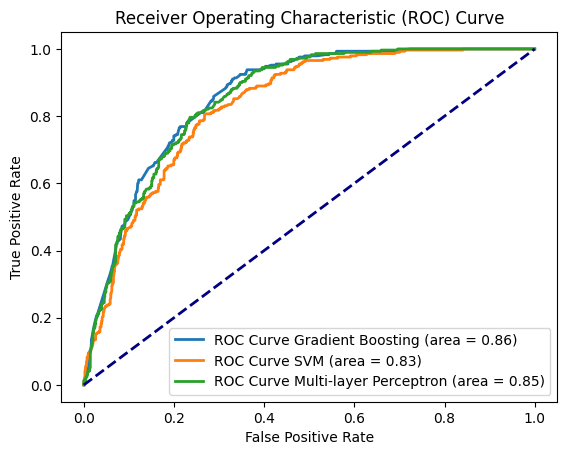

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


models = [final_model_gb, final_model_svc, final_model_mlp]
model_labels = ['Gradient Boosting', 'SVM', 'Multi-layer Perceptron']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.2, random_state=42)

# Create ROC curve for each model
plt.figure()
lw = 2

for model, label in zip(models, model_labels):
    try:
        # Try using predict_proba
        y_score = model.predict_proba(X_val)[:, 1]
    except AttributeError:
        # If predict_proba is not available, use decision_function
        y_score = model.decision_function(X_val)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=lw, label='ROC Curve {} (area = {:.2f})'.format(label, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
